In [1]:
import pandas as pd
from collections import defaultdict

In [2]:
raw_peaks_df = pd.read_csv('ENCSR885DVH/ENCFF879FSD.bed', sep='\t', header=None)


# For some reason (which I need to look into), there are multiple peaks
# with the same start and end coordinates. I need to collapse these entries
# down into a single interval.
interval_to_ids = defaultdict(lambda: [])
for r_i, row in raw_peaks_df.iterrows():
    chrm = row[0]
    begin = row[1]
    end = row[2]
    peak_id = row[3]
    interval_to_ids[(chrm, begin, end)].append(peak_id)
da = [
    (k[0], k[1], k[2], ','.join(v))
    for k, v in interval_to_ids.items()
]
peaks_df = pd.DataFrame(
    data=da,
    columns=[
        'chromsome', 
        'begin', 
        'end', 
        'peak_ids'
    ]
)
peaks_df

,chromsome,begin,end,peak_ids
0,chr1,100027916,100029543,"Peak_162534,Peak_189829,Peak_205380,Peak_23225..."
1,chr1,100036789,100037403,"Peak_133803,Peak_173137,Peak_67659"
2,chr1,100037554,100039283,"Peak_144687,Peak_179877,Peak_39266,Peak_44011,..."
3,chr1,100048434,100048996,"Peak_189438,Peak_222062"
4,chr1,100049436,100049815,"Peak_175134,Peak_199830"
...,...,...,...,...
135845,chrX,9995829,9996095,Peak_69685
135846,chrY,11097622,11097859,Peak_207213
135847,chrY,11098228,11099027,"Peak_119573,Peak_267499"
135848,chrY,12394970,12395294,"Peak_227283,Peak_267500"


In [3]:
rnaseq_df = pd.read_csv('output/ENCSR885DVH_ENCFF625ZBS.interval_counts.200_bp.ORIG.tsv', sep='\t')
rnaseq_df 

,interval_id,chromosome,interval_begin,interval_end,n_reads
0,chr1.1000_1200,chr1,1000,1200,0
1,chr1.1200_1400,chr1,1200,1400,0
2,chr1.1400_1600,chr1,1400,1600,0
3,chr1.1600_1800,chr1,1600,1800,0
4,chr1.1800_2000,chr1,1800,2000,0
...,...,...,...,...,...
7193533,chrY.57182169_57182369,chrY,57182169,57182369,0
7193534,chrY.57182369_57182569,chrY,57182369,57182569,0
7193535,chrY.57182569_57182769,chrY,57182569,57182769,0
7193536,chrY.57182769_57182969,chrY,57182769,57182969,0


In [13]:
def binary_search(ref, q):
    b = 0
    e = len(ref)-1
    mid = int((e-b)/2)
    for i in range(100):
        #print('({}, {}, {})'.format(b, mid, e), q)
        #print(ref[mid], ref[mid+1])
        if q > ref[mid] and q <= ref[mid+1]:
            return mid
        elif mid == 0:
            return None
        if q > ref[mid]:
            b = mid
        else:
            e = mid
        mid = int((e-b)/2)
        

In [23]:
chrm_to_peaks = {
    chrm: peaks_df.loc[peaks_df['chromsome'] == chrm]
    for chrm in set(peaks_df['chromsome'])
}
chrm_to_peaks = {
    chrm: peaks_df.sort_values(by='begin')
    for chrm, peaks_df in chrm_to_peaks.items()
}
chrm_to_peak_begins = {
    chrm: list(df['begin'])
    for chrm, df in chrm_to_peaks.items()
}
chrm_to_peak_ends = {
    chrm: list(df['end'])
    for chrm, df in chrm_to_peaks.items()
}

# Set to True to output messages
debug = False

ints_in_peaks = []
ints_outside_peaks = []
for r_i, row in rnaseq_df.iterrows():
    #if r_i > 1000:
    #    break
    if r_i % 500000 == 0:
        print("Interval {}/{}".format(r_i+1, len(rnaseq_df)))
    chrm = row['chromosome']
    peak_begins = chrm_to_peak_begins[chrm]
    peak_ends = chrm_to_peak_ends[chrm]
    begin = row['interval_begin']
    end = row['interval_end']
    p_i = binary_search(peak_begins, begin)
    if p_i is None:
        ints_outside_peaks.append(r_i)
    else:
        
        is_in_peak = begin >= peak_begins[p_i] and begin <= peak_ends[p_i]
        if debug:
            print("Interval begin: {}. Peak begin: {}. Peak end: {}".format(
                begin, 
                peak_begins[p_i], 
                peak_ends[p_i])
            )
            print("Is in peak? ", is_in_peak)
            print("Next peak begin: ", peak_begins[p_i+1])
            print()
        if is_in_peak:
            ints_in_peaks.append((r_i, p_i, chrm))
        else:
            ints_outside_peaks.append(r_i)
 
print('{} intervals in a peak'.format(len(ints_in_peaks)))
print('{} intervals outside a peak'.format(len(ints_outside_peaks)))
    

Interval 1/7193538
Interval 100001/7193538
Interval 200001/7193538
Interval 300001/7193538
Interval 400001/7193538
Interval 500001/7193538
Interval 600001/7193538
Interval 700001/7193538
Interval 800001/7193538
Interval 900001/7193538
Interval 1000001/7193538
Interval 1100001/7193538
Interval 1200001/7193538
Interval 1300001/7193538
Interval 1400001/7193538
Interval 1500001/7193538
Interval 1600001/7193538
Interval 1700001/7193538
Interval 1800001/7193538
Interval 1900001/7193538
Interval 2000001/7193538
Interval 2100001/7193538
Interval 2200001/7193538
Interval 2300001/7193538
Interval 2400001/7193538
Interval 2500001/7193538
Interval 2600001/7193538
Interval 2700001/7193538
Interval 2800001/7193538
Interval 2900001/7193538
Interval 3000001/7193538
Interval 3100001/7193538
Interval 3200001/7193538
Interval 3300001/7193538
Interval 3400001/7193538
Interval 3500001/7193538
Interval 3600001/7193538
Interval 3700001/7193538
Interval 3800001/7193538
Interval 3900001/7193538
Interval 400000

In [24]:
ints_in_peaks

[(45, 0, 'chr1'),
 (46, 0, 'chr1'),
 (47, 0, 'chr1'),
 (48, 0, 'chr1'),
 (76, 1, 'chr1'),
 (77, 1, 'chr1'),
 (78, 1, 'chr1'),
 (79, 1, 'chr1'),
 (80, 1, 'chr1'),
 (81, 1, 'chr1'),
 (104, 3, 'chr1'),
 (105, 3, 'chr1'),
 (106, 3, 'chr1'),
 (107, 3, 'chr1'),
 (557104, 0, 'chr10'),
 (557111, 1, 'chr10'),
 (557112, 1, 'chr10'),
 (558128, 23, 'chr10'),
 (558129, 23, 'chr10'),
 (558130, 23, 'chr10'),
 (558131, 23, 'chr10'),
 (558132, 23, 'chr10'),
 (558133, 23, 'chr10'),
 (563988, 95, 'chr10'),
 (563989, 95, 'chr10'),
 (563990, 95, 'chr10'),
 (563991, 95, 'chr10'),
 (575404, 381, 'chr10'),
 (575405, 381, 'chr10'),
 (575406, 381, 'chr10'),
 (626717, 1524, 'chr10'),
 (721031, 3049, 'chr10'),
 (721032, 3049, 'chr10'),
 (853649, 13, 'chr11'),
 (853683, 26, 'chr11'),
 (853684, 26, 'chr11'),
 (1128977, 3, 'chr12'),
 (1128978, 3, 'chr12'),
 (1128979, 3, 'chr12'),
 (1129020, 6, 'chr12'),
 (1129021, 6, 'chr12'),
 (1129022, 6, 'chr12'),
 (1129023, 6, 'chr12'),
 (1129024, 6, 'chr12'),
 (1129025, 6, 'chr

In [63]:
len(chrm_to_peaks['chr1'])
chrm_to_peaks['chr1'].iloc[10:40]

,chromsome,begin,end,peak_ids
14671,chr1,87571,88450,Peak_246707
10380,chr1,267973,268145,Peak_174628
10392,chr1,268730,269287,"Peak_170595,Peak_209537"
14285,chr1,778328,779267,"Peak_144566,Peak_1705,Peak_190094"
14344,chr1,795831,796861,"Peak_166464,Peak_185429"
14346,chr1,797425,797989,"Peak_150510,Peak_221711"
14353,chr1,804416,805054,"Peak_135033,Peak_37398"
14354,chr1,805418,805661,Peak_217337
14358,chr1,811425,811859,"Peak_140628,Peak_155160"
14360,chr1,812327,813021,Peak_35141


In [40]:
rnaseq_df.iloc[540:600]

,interval_id,chromosome,interval_begin,interval_end,n_reads
540,chr1.248817_249017,chr1,248817,249017,151
541,chr1.249017_249217,chr1,249017,249217,151
542,chr1.249217_249417,chr1,249217,249417,151
543,chr1.249417_249617,chr1,249417,249617,151
544,chr1.249617_249817,chr1,249617,249817,151
545,chr1.249817_250017,chr1,249817,250017,151
546,chr1.250017_250217,chr1,250017,250217,151
547,chr1.250217_250417,chr1,250217,250417,151
548,chr1.250417_250617,chr1,250417,250617,151
549,chr1.250617_250817,chr1,250617,250817,151


In [67]:
in_peak_counts = rnaseq_df.iloc[[x[0] for x in ints_in_peaks]]['n_reads']
out_peak_counts = rnaseq_df.iloc[ints_outside_peaks]['n_reads']
da = [
    (x, 'Within Peak')
    for x in in_peak_counts
]
da += [
    (x, 'Outside Peak')
    for x in out_peak_counts
]
df_in_out_peak_count = pd.DataFrame(
    data=da,
    columns=['Count', 'Peak-Status']
)
df_in_out_peak_count

,Count,Peak-Status
0,0,Within Peak
1,0,Within Peak
2,4,Within Peak
3,7,Within Peak
4,24,Within Peak
...,...,...
7193533,0,Outside Peak
7193534,0,Outside Peak
7193535,0,Outside Peak
7193536,0,Outside Peak


(0.0, 10.0)

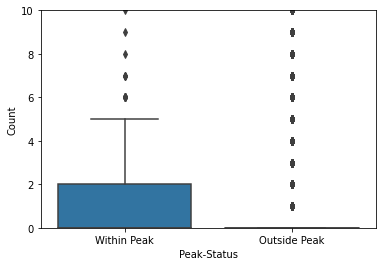

In [68]:
from matplotlib import pyplot as plt
import seaborn as sns

sns.boxplot(data=df_in_out_peak_count, x='Peak-Status', y='Count')
plt.ylim((0, 10))

<AxesSubplot:>

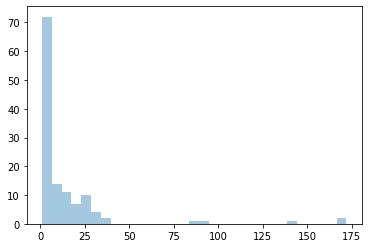

In [56]:
sns.distplot(in_peak_counts, kde=False)

<AxesSubplot:xlabel='n_reads'>

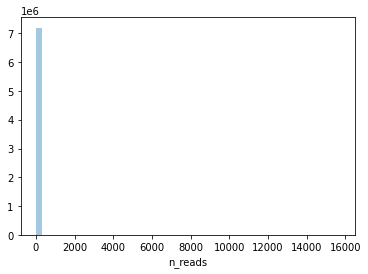

In [62]:
sns.distplot(out_peak_counts, kde=False)

In [61]:
from scipy.stats import ranksums

_, p_val = ranksums(in_peak_counts, out_peak_counts)
p_val

3.648269021208513e-17